# 11.2 Sparse coding (Olshausen & Field, 1996) モデル

## 11.2.1 Sparse codingと生成モデル
Sparse codingモデル([Olshausen & Field, *Nature*. 1996](https://www.nature.com/articles/381607a0))はV1のニューロンの応答特性を説明する**線形生成モデル** (linear generative model)である．まず，画像パッチ $\mathbf{x}$ が基底関数(basis function) $\mathbf{\Phi} = [\phi_j]$ のノイズを含む線形和で表されるとする (係数は $\mathbf{r}=[r_j]$ とする)．

$$
\mathbf{x} = \sum_j r_j \phi_j +\boldsymbol{\epsilon}= \mathbf{\Phi} \mathbf{r}+ \boldsymbol{\epsilon} \quad \tag{1}
$$

ただし，$\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \sigma^2 \mathbf{I})$ である．このモデルを神経ネットワークのモデルと考えると， $\mathbf{\Phi}$ は重み行列，係数 $\mathbf{r}$ は入力よりも高次の神経細胞の活動度を表していると解釈できる．ただし，$r_j$ は負の値も取るので単純に発火率と捉えられないのはこのモデルの欠点である．

Sparse codingでは神経活動 $\mathbf{r}$ が潜在変数の推定量を表現しているという仮定の下，少数の基底で画像 (や目的変数)を表すことを目的とする．要は上式において，ほとんどが0で，一部だけ0以外の値を取るという疎 (=sparse)な係数$\mathbf{r}$を求めたい．

### 確率的モデルの記述
````{margin}
```{note}
以後の記述は([Olshausen & Field, 1997](https://pubmed.ncbi.nlm.nih.gov/9425546/); [Barello et al., 2018](https://www.biorxiv.org/content/10.1101/399246v2.full))を参考にした．
```
````

入力される画像パッチ $\mathbf{x}_i\ (i=1, \cdots, N)$ の真の分布を $p_{data}(\mathbf{x})$ とする．また，$\mathbf{x}$ の生成モデルを $p(\mathbf{x}|\mathbf{\Phi})$ とする．さらに潜在変数 $\mathbf{r}$ の事前分布 (prior)を $p(\mathbf{r})$, 画像パッチ $\mathbf{x}$ の尤度 (likelihood)を $p(\mathbf{x}|\mathbf{r}, \mathbf{\Phi})$ とする．このとき，

$$
p(\mathbf{x}|\mathbf{\Phi})=\int p(\mathbf{x}|\mathbf{r}, \mathbf{\Phi})p(\mathbf{r})d\mathbf{r} \quad \tag{2}
$$

が成り立つ．$p(\mathbf{x}|\mathbf{r}, \mathbf{\Phi})$は，(1)式においてノイズ項を$\boldsymbol{\epsilon} \sim\mathcal{N}(\mathbf{0}, \sigma^2 \mathbf{I})$としたことから，

$$
p(\mathbf{x}|\ \mathbf{r}, \mathbf{\Phi})=\mathcal{N}\left(\mathbf{x}|\ \mathbf{\Phi} \mathbf{r}, \sigma^2 \mathbf{I} \right)=\frac{1}{Z_{\sigma}} \exp\left(-\frac{\|\mathbf{x} - \mathbf{\Phi} \mathbf{r}\|^2}{2\sigma^2}\right)\quad \tag{3}
$$

と表せる．ただし，$Z_{\sigma}$は規格化定数である．

### 事前分布の設定
事前分布$p(\mathbf{r})$としては，0においてピークがあり，裾の重い(heavy tail)を持つsparse distributionあるいは **super-Gaussian distribution** (Laplace 分布やCauchy分布などGaussian分布よりもkurtoticな分布)を用いるのが良い．このような分布では，$\mathbf{r}$の各要素$r_i$はほとんど0に等しく，ある入力に対しては大きな値を取る．$p(\mathbf{r})$は一般化して式(4), (5)のように表記する．

$$
\begin{align}
p(\mathbf{r})&=\prod_j p(r_j) \quad \tag{4}\\
p(r_j)&=\frac{1}{Z_{\beta}}\exp \left[-\beta S(r_j)\right] \quad \tag{5}
\end{align}
$$

ただし，$\beta$は逆温度(inverse temperature), $Z_{\beta}$は規格化定数 (分配関数) である[^can]．$S(x)$と分布の関係をまとめた表が以下となる (cf. [Harpur, 1997](https://pdfs.semanticscholar.org/be08/da912362bf40fe3ded78bdadc644f921b4e7.pdf))．

[^can]: これらの用語は統計力学における正準分布 (ボルツマン分布)から来ている．

|$S(r)$|$\dfrac{dS(r)}{dr}$|$p(r)$|分布名|尖度(kurtosis)|
|:-:|:-:|:-:|:-:|:-:|
|$r^2$|$2r$|$\dfrac{1}{\alpha \sqrt{2\pi}}\exp\left(-\dfrac{r^2}{2\alpha^2}\right)$|Gaussian 分布|0|
|$\vert r\vert$|$\text{sign}(r)$|$\dfrac{1}{2\alpha}\exp\left(-\dfrac{\vert r\vert}{\alpha}\right)$|Laplace 分布|3.0|
|$\ln (\alpha^2+r^2)$|$\dfrac{2r}{\alpha^2+r^2}$|$\dfrac{\alpha}{\pi}\dfrac{1}{\alpha^2+r^2}=\dfrac{\alpha}{\pi}\exp[-\ln (\alpha^2+r^2)]$|Cauchy 分布|-|

分布$p(r)$や$S(r)$を描画すると次のようになる．

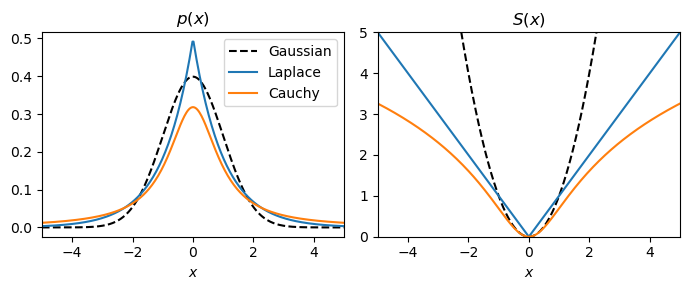

In [1]:
using PyPlot

x = range(-5, 5, length=300)
figure(figsize=(7,3))
subplot(1,2,1)
title(L"$p(x)$")
plot(x, 1/sqrt(2pi)*exp.(-(x.^2)/2), color="black", linestyle="--",label="Gaussian")
plot(x, 1/2*exp.(-abs.(x)), label="Laplace")
plot(x, 1 ./ (pi*(1 .+ x.^2)), label="Cauchy")
xlim(-5, 5); 
xlabel(L"$x$")
legend()

subplot(1,2,2)
title(L"S(x)")
plot(x, x.^2, color="black", linestyle="--",label="Gaussian")
plot(x, abs.(x), label="Laplace")
plot(x, log.(1 .+ x.^2), label="Cauchy")
xlim(-5, 5); ylim(0, 5)
xlabel(L"$x$")

tight_layout()

## 11.2.2 目的関数の設定と最適化
最適な生成モデルを得るために，入力される画像パッチの真の分布 $p_{data}(\mathbf{x})$と$\mathbf{x}$の生成モデル $p(\mathbf{x}|\mathbf{\Phi})$を近づける．このために，2つの分布のKullback-Leibler ダイバージェンス $D_{\text{KL}}\left(p_{data}(\mathbf{x}) \Vert\ p(\mathbf{x}|\mathbf{\Phi})\right)$を最小化したい．しかし，真の分布は得られないので，経験分布 

$$
\hat{p}_{data}(\mathbf{x}):=\frac{1}{N}\sum_{i=1}^N \delta(\mathbf{x}-\mathbf{x}_i) \tag{6}
$$

を近似として用いる ($\delta(\cdot)$ はDiracのデルタ関数である)．ゆえに$D_{\text{KL}}\left(\hat{p}_{data}(\mathbf{x}) \Vert\ p(\mathbf{x}|\mathbf{\Phi})\right)$を最小化する．

$$
\begin{align}
D_{\text{KL}}\left(\hat{p}_{data}(\mathbf{x}) \Vert\ p(\mathbf{x}|\mathbf{\Phi})\right)&=\int \hat{p}_{data}(\mathbf{x}) \log \frac{\hat{p}_{data}(\mathbf{x})}{p(\mathbf{x}|\mathbf{\Phi})} d\mathbf{x}\\
&=\mathbb{E}_{\hat{p}_{data}} \left[\ln \frac{\hat{p}_{data}(\mathbf{x})}{p(\mathbf{x}|\mathbf{\Phi})}\right]\\
&=\mathbb{E}_{\hat{p}_{data}} \left[\ln \hat{p}_{data}(\mathbf{x})\right]-\mathbb{E}_{\hat{p}_{data}} \left[\ln p(\mathbf{x}|\mathbf{\Phi})\right] \tag{7}
\end{align}
$$

が成り立つ．(7)式の1番目の項は一定なので，$D_{\text{KL}}\left(\hat{p}_{data}(\mathbf{x}) \Vert\ p(\mathbf{x}|\mathbf{\Phi})\right)$ を最小化するには$\mathbb{E}_{\hat{p}_{data}} \left[\ln p(\mathbf{x}|\mathbf{\Phi})\right]$を最大化すればよい．ここで，

$$
\mathbb{E}_{\hat{p}_{data}} \left[\ln p(\mathbf{x}|\mathbf{\Phi})\right]=\sum_{i=1}^N \hat{p}_{data}(\mathbf{x}_i)\ln p(\mathbf{x}_i|\mathbf{\Phi})=\frac{1}{N}\sum_{i=1}^N \ln p(\mathbf{x}_i|\mathbf{\Phi}) \tag{8}
$$

が成り立つ．また，(2)式より

$$
\ln p(\mathbf{x}|\mathbf{\Phi})=\ln \int p(\mathbf{x}|\mathbf{r}, \mathbf{\Phi})p(\mathbf{r})d\mathbf{r}
$$

が成り立つので，近似として $\displaystyle \int p(\mathbf{x}|\mathbf{r}, \mathbf{\Phi})p(\mathbf{r})d\mathbf{r}$ を $p(\mathbf{x}|\mathbf{r}, \mathbf{\Phi})p(\mathbf{r}) \left(=p(\mathbf{x}, \mathbf{r}| \mathbf{\Phi})\right)$ で評価する．これらの近似の下，最適な$\mathbf{\Phi}=\mathbf{\Phi}^*$は次のようにして求められる．

$$
\begin{align}
\mathbf{\Phi}^*&=\text{arg} \min_{\mathbf{\Phi}} \min_{\mathbf{r}} D_{\text{KL}}\left(\hat{p}_{data}(\mathbf{x}) \| p(\mathbf{x}|\mathbf{\Phi})\right)\\
&=\text{arg} \max_{\mathbf{\Phi}} \max_{\mathbf{r}} \mathbb{E}_{\hat{p}_{data}} \left[\ln p(\mathbf{x}|\mathbf{\Phi})\right]\\
&= \text{arg} \max_{\mathbf{\Phi}}\sum_{i=1}^N \max_{\mathbf{r}_i} \ln p(\mathbf{x}_i|\mathbf{\Phi})\\
&\approx \text{arg} \max_{\mathbf{\Phi}}\sum_{i=1}^N \max_{\mathbf{r}_i} \ln p(\mathbf{x}_i|\mathbf{r}_i, \mathbf{\Phi})p(\mathbf{r}_i)\\
&=\text{arg}\min_{\mathbf{\Phi}} \sum_{i=1}^N \min_{\mathbf{r}_i}\ E(\mathbf{x}_i, \mathbf{r}_i|\mathbf{\Phi})\tag{9}
\end{align}
$$

ただし，$\mathbf{x}_i$に対する神経活動を $\mathbf{r}_i$とした．また，$E(\mathbf{x}, \mathbf{r}|\mathbf{\Phi})$はコスト関数であり，次式のように表される．

$$
\begin{align}
E(\mathbf{x}, \mathbf{r}|\mathbf{\Phi}):=&-\ln p(\mathbf{x}|\mathbf{r}, \mathbf{\Phi})p(\mathbf{r})\\
=&\underbrace{\left\|\mathbf{x}-\mathbf{\Phi} \mathbf{r}\right\|^2}_{\text{preserve information}} + \lambda \underbrace{\sum_j S\left(r_j\right)}_{\text{sparseness of}\ r_j}\tag{10}
\end{align}
$$

ただし，$\lambda=2\sigma^2\beta$は正則化係数[^lam]であり，1行目から2行目へは式(3), (4), (5)を用いた．ここで，第1項が復元損失，第2項が罰則項 (正則化項)となっている．

式(9)で表される最適化手順を最適な$\mathbf{r}$と$\mathbf{\Phi}$を求める過程に分割しよう．まず， $\mathbf{\Phi}$を固定した下で$E(\mathbf{x}_n, \mathbf{r}_i|\mathbf{\Phi})$を最小化する$\mathbf{r}_i=\hat{\mathbf{r}}_i$を求める ([11.1.3](#locally-competitive-algorithm-lca))．

$$
\hat{\mathbf{r}}_i=\text{arg}\min_{\mathbf{r}_i}E(\mathbf{x}_i, \mathbf{r}_i|\mathbf{\Phi})\ \left(= \text{arg}\max_{\mathbf{r}_i}p(\mathbf{r}_i|\mathbf{x}_i)\right)
$$

これは $\mathbf{r}$ について **MAP推定** (maximum a posteriori estimation)を行うことに等しい．次に$\hat{\mathbf{r}}$を用いて

$$
\mathbf{\Phi}^*=\text{arg}\min_{\mathbf{\Phi}} \sum_{i=1}^N E(\mathbf{x}_i, \hat{\mathbf{r}}_i|\mathbf{\Phi})\ \left(= \text{arg}\max_{\mathbf{\Phi}} \prod_{i=1}^N p(\mathbf{x}_i|\hat{\mathbf{r}}_i, \mathbf{\Phi})\right)
$$

とすることにより，$\mathbf{\Phi}$を最適化する ([11.1.4](#id6))．こちらは $\mathbf{\Phi}$ について **最尤推定** (maximum likelihood estimation)を行うことに等しい．

[^lam]: この式から逆温度$\beta$が正則化の度合いを調整するパラメータであることがわかる．

##  11.2.3 Locally competitive algorithm (LCA) 
$\mathbf{r}$の勾配法による更新則は，$E$の微分により次のように得られる．

$$
\frac{d \mathbf{r}}{dt}= -\frac{\eta_\mathbf{r}}{2}\frac{\partial E}{\partial \mathbf{r}}=\eta_\mathbf{r} \cdot\left[\mathbf{\Phi}^T (\mathbf{x}-\mathbf{\Phi}\mathbf{r})- \frac{\lambda}{2}S'\left(\mathbf{r}\right)\right]
$$

ただし，$\eta_{\mathbf{r}}$は学習率である．この式により$\mathbf{r}$が収束するまで最適化するが，単なる勾配法ではなく，(Olshausen & Field, 1996)では**共役勾配法** (conjugate gradient method)を用いている．しかし，共役勾配法は実装が煩雑で非効率であるため，より効率的かつ生理学的な妥当性の高い学習法として，**LCA**  (locally competitive algorithm)が提案されている ([Rozell et al., *Neural Comput*. 2008](https://www.ece.rice.edu/~eld1/papers/Rozell08.pdf))．LCAは**側抑制** (local competition, lateral inhibition)と**閾値関数** (thresholding function)を用いる更新則である．LCAによる更新を行うRNNは通常のRNNとは異なり，コスト関数(またはエネルギー関数)を最小化する動的システムである．このような機構はHopfield networkで用いられているために，Olshausenは**Hopfield trick**と呼んでいる．

### 軟判定閾値関数を用いる場合 (ISTA)
$S(x)=|x|$とした場合の閾値関数を用いる手法として**ISTA**(Iterative Shrinkage Thresholding Algorithm)がある．ISTAはL1-norm正則化項に対する近接勾配法で，要はLasso回帰に用いる勾配法である．

解くべき問題は次式で表される．

$$
\mathbf{r} = \mathop{\rm arg~min}\limits_{\mathbf{r}}\left\{\|\mathbf{x}-\mathbf{\Phi}\mathbf{r}\|^2_2+\lambda\|\mathbf{r}\|_1\right\}
$$

詳細は後述するが，次のように更新することで解が得られる．

1. $\mathbf{r}(0)$を要素が全て0のベクトルで初期化：$\mathbf{r}(0)=\mathbf{0}$
2. $\mathbf{r}_*(t+1)=\mathbf{r}(t)+\eta_\mathbf{r}\cdot \mathbf{\Phi}^T(\mathbf{x}-\mathbf{\Phi}\mathbf{r}(t))$
3. $\mathbf{r}(t+1) = \Theta_\lambda(\mathbf{r}_*(t+1))$
4. $\mathbf{r}$が収束するまで2と3を繰り返す

ここで$\Theta_\lambda(\cdot)$は**軟判定閾値関数** (Soft thresholding function)と呼ばれ，次式で表される．

$$
\Theta_\lambda(y)= 
\begin{cases} 
y-\lambda & (y>\lambda)\\ 
0 & (-\lambda\leq y\leq\lambda)\\ 
 y+\lambda & (y<-\lambda) 
\end{cases}
$$

$\Theta_\lambda(\cdot)$を関数として定義すると次のようになる [^softthr]．


[^softthr]: ReLU (ランプ関数)は`max(x, 0)`で実装できる．この点から考えればReLUを軟判定非負閾値関数 (soft nonnegative thresholding function)と捉えることもできる ([Papyan et al., 2018](https://ieeexplore.ieee.org/document/8398588))．

In [2]:
# thresholding function of S(x)=|x|
function soft_thresholding_func(x, lmda)
    max(x - lmda, 0) - max(-x - lmda, 0)
end

soft_thresholding_func (generic function with 1 method)

次に$\Theta_\lambda(\cdot)$を描画すると次のようになる．

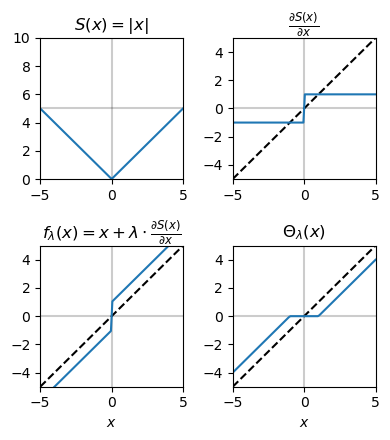

In [3]:
xmin, xmax = -5, 5
x = range(xmin, xmax, length=100)
y = soft_thresholding_func.(x, 1)

figure(figsize=(4,4.5))
subplot(2,2,1)
title(L"$S(x)=|x|$")
plot(x, abs.(x))
xlim(xmin, xmax); ylim(0, 10)
hlines(y=xmax, xmin=xmin, xmax=xmax, color="k", alpha=0.2)
vlines(x=0, ymin=0, ymax=xmax*2, color="k", alpha=0.2)

subplot(2,2,2)
title(L"$\frac{\partial S(x)}{\partial x}$")
plot(x, x, "k--")
plot(x, sign.(x))
xlim(xmin, xmax); ylim(xmin, xmax)
hlines(y=0, xmin=xmin, xmax=xmax, color="k", alpha=0.2)
vlines(x=0, ymin=xmin, ymax=xmax, color="k", alpha=0.2)

subplot(2,2,3)
title(L"$f_\lambda(x)=x+\lambda\cdot\frac{\partial S(x)}{\partial x}$")
plot(x, x, "k--")
plot(x, x + 1*sign.(x))
xlabel(L"$x$")
xlim(-5, 5); ylim(-5, 5)
hlines(y=0, xmin=xmin, xmax=xmax, color="k", alpha=0.2)
vlines(x=0, ymin=xmin, ymax=xmax, color="k", alpha=0.2)

subplot(2,2,4)
title(L"$\Theta_\lambda(x)$")
plot(x, x, "k--")
plot(x, y)
xlabel(L"$x$")
xlim(-5, 5); ylim(-5, 5)
hlines(y=0, xmin=xmin, xmax=xmax, color="k", alpha=0.2)
vlines(x=0, ymin=xmin, ymax=xmax, color="k", alpha=0.2)

tight_layout()

なお，軟判定閾値関数は次の目的関数$C$を最小化する$x$を求めることで導出できる．

$$
C=\frac{1}{2}(y-x)^2+\lambda |x|
$$

ただし，$x, y, \lambda$はスカラー値とする．$|x|$が微分できないが，これは場合分けを考えることで解決する．$x\geq 0$を考えると，(6)式は

$$
C=\frac{1}{2}(y-x)^2+\lambda x = \{x-(y-\lambda)\}^2+\lambda(y-\lambda)
$$

となる．(7)式の最小値を与える$x$は場合分けをして考えると，$y-\lambda\geq0$のとき二次関数の頂点を考えて$x=y-\lambda$となる． 一方で$y-\lambda<0$のときは$x\geq0$において単調増加な関数となるので，最小となるのは$x=0$のときである．同様の議論を$x\leq0$に対しても行うことで (5)式が得られる．

なお，閾値関数としては軟判定閾値関数だけではなく，硬判定閾値関数や$y=x - \text{tanh}(x)$ (Tanh-shrink)など様々な関数を用いることができる．

## 11.2.4 重み行列の更新則
$\mathbf{r}$が収束したら勾配法により$\mathbf{\Phi}$を更新する．

$$
\Delta \phi_i(\boldsymbol{x}) = -\eta \frac{\partial E}{\partial \mathbf{\Phi}}=\eta\cdot\left[\left([\mathbf{x}-\mathbf{\Phi}\mathbf{r}\right)\mathbf{r}^T\right]
$$

## 11.2.5 Sparse coding networkの実装
ネットワークは入力層を含め2層の単純な構造である．今回は，入力はランダムに切り出した16×16 (＝256)の画像パッチとし，これを入力層の256個のニューロンが受け取るとする．入力層のニューロンは次層の100個のニューロンに投射するとする．100個のニューロンが入力をSparseに符号化するようにその活動および重み行列を最適化する．

### 画像データの読み込み
データは<http://www.rctn.org/bruno/sparsenet/>からダウンロードできる [^datasets]．`IMAGES_RAW.mat`は10枚の自然画像で，`IMAGES.mat`はそれを白色化したものである．`mat`ファイルの読み込みには[MAT.jl](https://github.com/JuliaIO/MAT.jl)を用いる．

[^datasets]: これはアメリカ北西部で撮影された自然画像であり，[van Hateren's Natural Image Dataset](http://bethgelab.org/datasets/vanhateren/)から取得されたものである．

In [4]:
using MAT
#using PyPlot

In [5]:
# datasets from http://www.rctn.org/bruno/sparsenet/
mat_images_raw = matopen("../_static/datasets/IMAGES_RAW.mat")
imgs_raw = read(mat_images_raw, "IMAGESr")

mat_images = matopen("../_static/datasets/IMAGES.mat")
imgs = read(mat_images, "IMAGES")

close(mat_images_raw)
close(mat_images)

画像データを描画する．

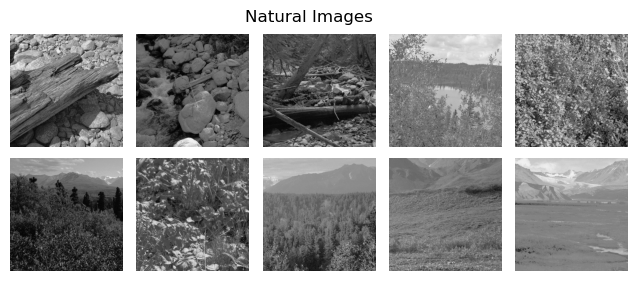

In [6]:
figure(figsize=(8, 3))
subplots_adjust(hspace=0.1, wspace=0.1)
for i=1:10
    subplot(2, 5, i)
    imshow(imgs_raw[:,:,i], cmap="gray")
    axis("off")
end
suptitle("Natural Images", fontsize=12)
subplots_adjust(top=0.9)  

### モデルの定義
必要なパッケージを読み込む．

In [7]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using LinearAlgebra
using Random
using Statistics
using ProgressMeter

モデルを定義する．

In [8]:
@kwdef struct OFParameter{FT}
    lr_r::FT = 1e-2 # learning rate of r
    lr_Phi::FT = 1e-2 # learning rate of Phi
    lmda::FT = 5e-3 # regularization parameter
end

@kwdef mutable struct OlshausenField1996Model{FT}
    param::OFParameter = OFParameter{FT}()
    num_inputs::Int32
    num_units::Int32
    batch_size::Int32
    r::Array{FT} = zeros(batch_size, num_units) # activity of neurons
    Phi::Array{FT} = randn(num_inputs, num_units) .* sqrt(1/num_units)
end

パラメータを更新する関数を定義する．

In [9]:
function updateOF!(variable::OlshausenField1996Model, param::OFParameter, inputs::Array, training::Bool)
    @unpack num_inputs, num_units, batch_size, r, Phi = variable
    @unpack lr_r, lr_Phi, lmda = param

    # Updates                
    error = inputs .- r * Phi'
    r_ = r +lr_r .* error * Phi

    r[:, :] = soft_thresholding_func.(r_, lmda)

    if training 
        error = inputs - r * Phi'
        dPhi = error' * r
        Phi[:, :] += lr_Phi * dPhi
    end
    
    return error
end

updateOF! (generic function with 1 method)

行ごとに正規化する関数を定義する．

In [10]:
function normalize_rows(A::Array)
    return A ./ sqrt.(sum(A.^2, dims=1) .+ 1e-8)
end

normalize_rows (generic function with 1 method)

損失関数を定義する．

In [11]:
function calculate_total_error(error, r, lmda)
    recon_error = mean(error.^2)
    sparsity_r = lmda*mean(abs.(r)) 
    return recon_error + sparsity_r
end

calculate_total_error (generic function with 1 method)

シミュレーションを実行する関数を定義する．外側の`for loop`では画像パッチの作成と`r`の初期化を行う．内側の`for loop`では`r`が収束するまで更新を行い，収束したときに重み行列`Phi`を更新する．

In [12]:
function run_simulation(imgs, num_iter, nt_max, batch_size, sz, num_units, eps)
    H, W, num_images = size(imgs)
    num_inputs = sz^2

    model = OlshausenField1996Model{Float32}(num_inputs=num_inputs, num_units=num_units, batch_size=batch_size)
    errorarr = zeros(num_iter) # Vector to save errors    
    
    # Run simulation
    @showprogress "Computing..." for iter in 1:num_iter
        # Get the coordinates of the upper left corner of clopping image randomly.
        beginx = rand(1:W-sz, batch_size)
        beginy = rand(1:H-sz, batch_size)

        inputs = zeros(batch_size, num_inputs)  # Input image patches

        # Get images randomly
        for i in 1:batch_size        
            idx = rand(1:num_images)
            img = imgs[:, :, idx]
            clop = img[beginy[i]:beginy[i]+sz-1, beginx[i]:beginx[i]+sz-1][:]
            inputs[i, :] = clop .- mean(clop)
        end

        model.r = zeros(batch_size, num_units) # Reset r states
        model.Phi = normalize_rows(model.Phi) # Normalize weights
        # Input image patches until latent variables are converged 
        r_tm1 = zeros(batch_size, num_units)  # set previous r (t minus 1)

        for t in 1:nt_max
            # Update r without update weights 
            error = updateOF!(model, model.param, inputs, false)

            dr = model.r - r_tm1 

            # Compute norm of r
            dr_norm = sqrt(sum(dr.^2)) / sqrt(sum(r_tm1.^2) + 1e-8)
            r_tm1 .= model.r # update r_tm1

            # Check convergence of r, then update weights
            if dr_norm < eps
                error = updateOF!(model, model.param, inputs, true)
                errorarr[iter] = calculate_total_error(error, model.r, model.param.lmda) # Append errors
                break
            end

            # If failure to convergence, break and print error
            if t >= nt_max-1
                print("Error at patch:", iter_, dr_norm)
                errorarr[iter] = calculate_total_error(error, model.r, model.param.lmda) # Append errors
                break
            end
        end
        # Print moving average error
        if iter % 100 == 0
            moving_average_error = mean(errorarr[iter-99:iter])
            println("iter: ", iter, "/", num_iter, ", Moving average error:", moving_average_error)
        end
    end
    return model, errorarr
end

run_simulation (generic function with 1 method)

`r_tm1 .= model.r`の部分は，要素ごとのコピーを実行している．`r_tm1 = copy(model.r)`でもよいが，新たなメモリ割り当てが生じるので避けている．`@. r_tm1 = model.r`としてもよい．

### シミュレーションの実行

In [13]:
# Simulation constants
num_iter = 500 # number of iterations
nt_max = 1000 # Maximum number of simulation time
batch_size = 250 # Batch size

sz = 16 # image patch size
num_units = 100 # number of neurons (units)
eps = 1e-2 # small value which determines convergence

model, errorarr = run_simulation(imgs, num_iter, nt_max, batch_size, sz, num_units, eps)

Computing...  0%|█                                      |  ETA: 0:19:13

Computing...  1%|█                                      |  ETA: 0:09:15

Computing...  1%|█                                      |  ETA: 0:07:34

Computing...  1%|█                                      |  ETA: 0:06:34

Computing...  1%|█                                      |  ETA: 0:05:53

Computing...  1%|█                                      |  ETA: 0:05:24

Computing...  2%|█                                      |  ETA: 0:05:02

Computing...  2%|█                                      |  ETA: 0:04:45

Computing...  2%|█                                      |  ETA: 0:04:31

Computing...  2%|█                                      |  ETA: 0:04:20

Computing...  2%|█                                      |  ETA: 0:04:10

Computing...  3%|██                                     |  ETA: 0:04:02

Computing...  3%|██                                     |  ETA: 0:03:55

Computing...  3%|██                                     |  ETA: 0:03:49

Computing...  3%|██                                     |  ETA: 0:03:43

Computing...  3%|██                                     |  ETA: 0:03:38

Computing...  4%|██                                     |  ETA: 0:03:34

Computing...  4%|██                                     |  ETA: 0:03:30

Computing...  4%|██                                     |  ETA: 0:03:27

Computing...  4%|██                                     |  ETA: 0:03:23

Computing...  4%|██                                     |  ETA: 0:03:21

Computing...  5%|██                                     |  ETA: 0:03:18

Computing...  5%|██                                     |  ETA: 0:03:15

Computing...  5%|██                                     |  ETA: 0:03:13

Computing...  5%|███                                    |  ETA: 0:03:10

Computing...  5%|███                                    |  ETA: 0:03:08

Computing...  6%|███                                    |  ETA: 0:03:06

Computing...  6%|███                                    |  ETA: 0:03:04

Computing...  6%|███                                    |  ETA: 0:03:02

Computing...  6%|███                                    |  ETA: 0:03:00

Computing...  6%|███                                    |  ETA: 0:02:59

Computing...  7%|███                                    |  ETA: 0:02:57

Computing...  7%|███                                    |  ETA: 0:02:55

Computing...  7%|███                                    |  ETA: 0:02:54

Computing...  7%|███                                    |  ETA: 0:02:52

Computing...  7%|███                                    |  ETA: 0:02:51

Computing...  8%|███                                    |  ETA: 0:02:50

Computing...  8%|████                                   |  ETA: 0:02:48[3

Computing...  8%|████                                   |  ETA: 0:02:47

Computing...  8%|████                                   |  ETA: 0:02:46

Computing...  8%|████                                   |  ETA: 0:02:45[39

Computing...  9%|████                                   |  ETA: 0:02:43

Computing...  9%|████                                   |  ETA: 0:02:44

Computing...  9%|████                                   |  ETA: 0:02:43

Computing...  9%|████                                   |  ETA: 0:02:41

Computing...  9%|████                                   |  ETA: 0:02:40

Computing... 10%|████                                   |  ETA: 0:02:39

Computing... 10%|████                                   |  ETA: 0:02:38

Computing... 10%|████                                   |  ETA: 0:02:37[39

Computing... 10%|████                                   |  ETA: 0:02:36

Computing... 10%|█████                                  |  ETA: 0:02:35

Computing... 11%|█████                                  |  ETA: 0:02:34

Computing... 11%|█████                                  |  ETA: 0:02:33

Computing... 11%|█████                                  |  ETA: 0:02:32

Computing... 11%|█████                                  |  ETA: 0:02:32

Computing... 11%|█████                                  |  ETA: 0:02:31

Computing... 12%|█████                                  |  ETA: 0:02:30

Computing... 12%|█████                                  |  ETA: 0:02:29

Computing... 12%|█████                                  |  ETA: 0:02:28

Computing... 12%|█████                                  |  ETA: 0:02:27

Computing... 12%|█████                                  |  ETA: 0:02:27

Computing... 13%|█████                                  |  ETA: 0:02:26

Computing... 13%|█████                                  |  ETA: 0:02:25

Computing... 13%|██████                                 |  ETA: 0:02:25

Computing... 13%|██████                                 |  ETA: 0:02:24

Computing... 13%|██████                                 |  ETA: 0:02:23

Computing... 14%|██████                                 |  ETA: 0:02:22

Computing... 14%|██████                                 |  ETA: 0:02:22

Computing... 14%|██████                                 |  ETA: 0:02:21

Computing... 14%|██████                                 |  ETA: 0:02:21

Computing... 14%|██████                                 |  ETA: 0:02:20

Computing... 15%|██████                                 |  ETA: 0:02:19

Computing... 15%|██████                                 |  ETA: 0:02:19

Computing... 15%|██████                                 |  ETA: 0:02:18

Computing... 15%|██████                                 |  ETA: 0:02:17

Computing... 15%|███████                                |  ETA: 0:02:17

Computing... 16%|███████                                |  ETA: 0:02:16[39

Computing... 16%|███████                                |  ETA: 0:02:16

Computing... 16%|███████                                |  ETA: 0:02:15

Computing... 16%|███████                                |  ETA: 0:02:15

Computing... 16%|███████                                |  ETA: 0:02:14

Computing... 17%|███████                                |  ETA: 0:02:14

Computing... 17%|███████                                |  ETA: 0:02:13

Computing... 17%|███████                                |  ETA: 0:02:13

Computing... 17%|███████                                |  ETA: 0:02:12

Computing... 17%|███████                                |  ETA: 0:02:11

Computing... 18%|███████                                |  ETA: 0:02:11

Computing... 18%|███████                                |  ETA: 0:02:10

Computing... 18%|████████                               |  ETA: 0:02:10

Computing... 18%|████████                               |  ETA: 0:02:09

Computing... 18%|████████                               |  ETA: 0:02:09

Computing... 19%|████████                               |  ETA: 0:02:08

Computing... 19%|████████                               |  ETA: 0:02:08

Computing... 19%|████████                               |  ETA: 0:02:08

Computing... 19%|████████                               |  ETA: 0:02:07

Computing... 19%|████████                               |  ETA: 0:02:07

Computing... 20%|████████                               |  ETA: 0:02:06

Computing... 20%|████████                               |  ETA: 0:02:06

Computing... 20%|████████                               |  ETA: 0:02:06

iter: 100/500, Moving average error:0.05296204705899751


Computing... 20%|████████                               |  ETA: 0:02:05

Computing... 20%|████████                               |  ETA: 0:02:05

Computing... 21%|█████████                              |  ETA: 0:02:04

Computing... 21%|█████████                              |  ETA: 0:02:04

Computing... 21%|█████████                              |  ETA: 0:02:03

Computing... 21%|█████████                              |  ETA: 0:02:03

Computing... 21%|█████████                              |  ETA: 0:02:03

Computing... 22%|█████████                              |  ETA: 0:02:02

Computing... 22%|█████████                              |  ETA: 0:02:02

Computing... 22%|█████████                              |  ETA: 0:02:01

Computing... 22%|█████████                              |  ETA: 0:02:01

Computing... 22%|█████████                              |  ETA: 0:02:01

Computing... 23%|█████████                              |  ETA: 0:02:00

Computing... 23%|█████████                              |  ETA: 0:02:00

Computing... 23%|█████████                              |  ETA: 0:01:59

Computing... 23%|██████████                             |  ETA: 0:01:59

Computing... 23%|██████████                             |  ETA: 0:01:59

Computing... 24%|██████████                             |  ETA: 0:01:58

Computing... 24%|██████████                             |  ETA: 0:01:58

Computing... 24%|██████████                             |  ETA: 0:01:57

Computing... 24%|██████████                             |  ETA: 0:01:57

Computing... 24%|██████████                             |  ETA: 0:01:57

Computing... 25%|██████████                             |  ETA: 0:01:56

Computing... 25%|██████████                             |  ETA: 0:01:56

Computing... 25%|██████████                             |  ETA: 0:01:55

Computing... 25%|██████████                             |  ETA: 0:01:55

Computing... 26%|██████████                             |  ETA: 0:01:55

Computing... 26%|███████████                            |  ETA: 0:01:54

Computing... 26%|███████████                            |  ETA: 0:01:54

Computing... 26%|███████████                            |  ETA: 0:01:53

Computing... 26%|███████████                            |  ETA: 0:01:53

Computing... 27%|███████████                            |  ETA: 0:01:53

Computing... 27%|███████████                            |  ETA: 0:01:52

Computing... 27%|███████████                            |  ETA: 0:01:52

Computing... 27%|███████████                            |  ETA: 0:01:52

Computing... 27%|███████████                            |  ETA: 0:01:51

Computing... 28%|███████████                            |  ETA: 0:01:51

Computing... 28%|███████████                            |  ETA: 0:01:51

Computing... 28%|███████████                            |  ETA: 0:01:50

Computing... 28%|███████████                            |  ETA: 0:01:50

Computing... 28%|████████████                           |  ETA: 0:01:49

Computing... 29%|████████████                           |  ETA: 0:01:49

Computing... 29%|████████████                           |  ETA: 0:01:49

Computing... 29%|████████████                           |  ETA: 0:01:48

Computing... 29%|████████████                           |  ETA: 0:01:48

Computing... 29%|████████████                           |  ETA: 0:01:47

Computing... 30%|████████████                           |  ETA: 0:01:47

Computing... 30%|████████████                           |  ETA: 0:01:47

Computing... 30%|████████████                           |  ETA: 0:01:46

Computing... 30%|████████████                           |  ETA: 0:01:46

Computing... 30%|████████████                           |  ETA: 0:01:46

Computing... 31%|████████████                           |  ETA: 0:01:45

Computing... 31%|█████████████                          |  ETA: 0:01:45

Computing... 31%|█████████████                          |  ETA: 0:01:45

Computing... 31%|█████████████                          |  ETA: 0:01:44

Computing... 31%|█████████████                          |  ETA: 0:01:44

Computing... 32%|█████████████                          |  ETA: 0:01:43

Computing... 32%|█████████████                          |  ETA: 0:01:43

Computing... 32%|█████████████                          |  ETA: 0:01:43

Computing... 32%|█████████████                          |  ETA: 0:01:42

Computing... 32%|█████████████                          |  ETA: 0:01:42

Computing... 33%|█████████████                          |  ETA: 0:01:42

Computing... 33%|█████████████                          |  ETA: 0:01:41

Computing... 33%|█████████████                          |  ETA: 0:01:41

Computing... 33%|█████████████                          |  ETA: 0:01:41

Computing... 33%|██████████████                         |  ETA: 0:01:40

Computing... 34%|██████████████                         |  ETA: 0:01:40

Computing... 34%|██████████████                         |  ETA: 0:01:40

Computing... 34%|██████████████                         |  ETA: 0:01:39

Computing... 34%|██████████████                         |  ETA: 0:01:39

Computing... 34%|██████████████                         |  ETA: 0:01:39

Computing... 35%|██████████████                         |  ETA: 0:01:38

Computing... 35%|██████████████                         |  ETA: 0:01:38

Computing... 35%|██████████████                         |  ETA: 0:01:38

Computing... 35%|██████████████                         |  ETA: 0:01:37

Computing... 35%|██████████████                         |  ETA: 0:01:37

Computing... 36%|██████████████                         |  ETA: 0:01:37

Computing... 36%|██████████████                         |  ETA: 0:01:36

Computing... 36%|███████████████                        |  ETA: 0:01:36

Computing... 36%|███████████████                        |  ETA: 0:01:35

Computing... 37%|███████████████                        |  ETA: 0:01:35

Computing... 37%|███████████████                        |  ETA: 0:01:35

Computing... 37%|███████████████                        |  ETA: 0:01:34

Computing... 37%|███████████████                        |  ETA: 0:01:34

Computing... 37%|███████████████                        |  ETA: 0:01:34

Computing... 38%|███████████████                        |  ETA: 0:01:33

Computing... 38%|███████████████                        |  ETA: 0:01:33

Computing... 38%|███████████████                        |  ETA: 0:01:33

Computing... 38%|███████████████                        |  ETA: 0:01:32

Computing... 38%|███████████████                        |  ETA: 0:01:32

Computing... 39%|████████████████                       |  ETA: 0:01:32

Computing... 39%|████████████████                       |  ETA: 0:01:31

Computing... 39%|████████████████                       |  ETA: 0:01:31

Computing... 39%|████████████████                       |  ETA: 0:01:31

Computing... 39%|████████████████                       |  ETA: 0:01:30

Computing... 40%|████████████████                       |  ETA: 0:01:30

Computing... 40%|████████████████                       |  ETA: 0:01:30

Computing... 40%|████████████████                       |  ETA: 0:01:29

iter: 200/500, Moving average error:0.049105051962369355


Computing... 40%|████████████████                       |  ETA: 0:01:29

Computing... 40%|████████████████                       |  ETA: 0:01:29

Computing... 41%|████████████████                       |  ETA: 0:01:28

Computing... 41%|████████████████                       |  ETA: 0:01:28

Computing... 41%|████████████████                       |  ETA: 0:01:28

Computing... 41%|█████████████████                      |  ETA: 0:01:27

Computing... 41%|█████████████████                      |  ETA: 0:01:27

Computing... 42%|█████████████████                      |  ETA: 0:01:27

Computing... 42%|█████████████████                      |  ETA: 0:01:26

Computing... 42%|█████████████████                      |  ETA: 0:01:26

Computing... 42%|█████████████████                      |  ETA: 0:01:26

Computing... 42%|█████████████████                      |  ETA: 0:01:26

Computing... 43%|█████████████████                      |  ETA: 0:01:25

Computing... 43%|█████████████████                      |  ETA: 0:01:25

Computing... 43%|█████████████████                      |  ETA: 0:01:25

Computing... 43%|█████████████████                      |  ETA: 0:01:24

Computing... 43%|█████████████████                      |  ETA: 0:01:24

Computing... 44%|██████████████████                     |  ETA: 0:01:24

Computing... 44%|██████████████████                     |  ETA: 0:01:23

Computing... 44%|██████████████████                     |  ETA: 0:01:23

Computing... 44%|██████████████████                     |  ETA: 0:01:23

Computing... 44%|██████████████████                     |  ETA: 0:01:23

Computing... 45%|██████████████████                     |  ETA: 0:01:22

Computing... 45%|██████████████████                     |  ETA: 0:01:22

Computing... 45%|██████████████████                     |  ETA: 0:01:22

Computing... 45%|██████████████████                     |  ETA: 0:01:21

Computing... 45%|██████████████████                     |  ETA: 0:01:21

Computing... 46%|██████████████████                     |  ETA: 0:01:21

Computing... 46%|██████████████████                     |  ETA: 0:01:20

Computing... 46%|██████████████████                     |  ETA: 0:01:20

Computing... 46%|███████████████████                    |  ETA: 0:01:20

Computing... 46%|███████████████████                    |  ETA: 0:01:19

Computing... 47%|███████████████████                    |  ETA: 0:01:19

Computing... 47%|███████████████████                    |  ETA: 0:01:19

Computing... 47%|███████████████████                    |  ETA: 0:01:18

Computing... 47%|███████████████████                    |  ETA: 0:01:18

Computing... 47%|███████████████████                    |  ETA: 0:01:18

Computing... 48%|███████████████████                    |  ETA: 0:01:18

Computing... 48%|███████████████████                    |  ETA: 0:01:17

Computing... 48%|███████████████████                    |  ETA: 0:01:17

Computing... 48%|███████████████████                    |  ETA: 0:01:17

Computing... 48%|███████████████████                    |  ETA: 0:01:16

Computing... 49%|███████████████████                    |  ETA: 0:01:16

Computing... 49%|████████████████████                   |  ETA: 0:01:16

Computing... 49%|████████████████████                   |  ETA: 0:01:15

Computing... 49%|████████████████████                   |  ETA: 0:01:15

Computing... 49%|████████████████████                   |  ETA: 0:01:15

Computing... 50%|████████████████████                   |  ETA: 0:01:14

Computing... 50%|████████████████████                   |  ETA: 0:01:14

Computing... 50%|████████████████████                   |  ETA: 0:01:14

Computing... 50%|████████████████████                   |  ETA: 0:01:13

Computing... 50%|████████████████████                   |  ETA: 0:01:13

Computing... 51%|████████████████████                   |  ETA: 0:01:13

Computing... 51%|████████████████████                   |  ETA: 0:01:12

Computing... 51%|████████████████████                   |  ETA: 0:01:12

Computing... 51%|████████████████████                   |  ETA: 0:01:12

Computing... 51%|█████████████████████                  |  ETA: 0:01:12

Computing... 52%|█████████████████████                  |  ETA: 0:01:11

Computing... 52%|█████████████████████                  |  ETA: 0:01:11

Computing... 52%|█████████████████████                  |  ETA: 0:01:11

Computing... 52%|█████████████████████                  |  ETA: 0:01:10

Computing... 52%|█████████████████████                  |  ETA: 0:01:10

Computing... 53%|█████████████████████                  |  ETA: 0:01:10

Computing... 53%|█████████████████████                  |  ETA: 0:01:09

Computing... 53%|█████████████████████                  |  ETA: 0:01:09

Computing... 53%|█████████████████████                  |  ETA: 0:01:09

Computing... 53%|█████████████████████                  |  ETA: 0:01:08

Computing... 54%|█████████████████████                  |  ETA: 0:01:08

Computing... 54%|█████████████████████                  |  ETA: 0:01:08

Computing... 54%|██████████████████████                 |  ETA: 0:01:08

Computing... 54%|██████████████████████                 |  ETA: 0:01:07

Computing... 54%|██████████████████████                 |  ETA: 0:01:07

Computing... 55%|██████████████████████                 |  ETA: 0:01:07

Computing... 55%|██████████████████████                 |  ETA: 0:01:06

Computing... 55%|██████████████████████                 |  ETA: 0:01:06

Computing... 55%|██████████████████████                 |  ETA: 0:01:06

Computing... 55%|██████████████████████                 |  ETA: 0:01:05

Computing... 56%|██████████████████████                 |  ETA: 0:01:05

Computing... 56%|██████████████████████                 |  ETA: 0:01:05

Computing... 56%|██████████████████████                 |  ETA: 0:01:04

Computing... 56%|██████████████████████                 |  ETA: 0:01:04

Computing... 56%|██████████████████████                 |  ETA: 0:01:04

Computing... 57%|███████████████████████                |  ETA: 0:01:04

Computing... 57%|███████████████████████                |  ETA: 0:01:03

Computing... 57%|███████████████████████                |  ETA: 0:01:03

Computing... 57%|███████████████████████                |  ETA: 0:01:03

Computing... 57%|███████████████████████                |  ETA: 0:01:02

Computing... 58%|███████████████████████                |  ETA: 0:01:02

Computing... 58%|███████████████████████                |  ETA: 0:01:02

Computing... 58%|███████████████████████                |  ETA: 0:01:01

Computing... 58%|███████████████████████                |  ETA: 0:01:01

Computing... 58%|███████████████████████                |  ETA: 0:01:01

Computing... 59%|███████████████████████                |  ETA: 0:01:01

Computing... 59%|███████████████████████                |  ETA: 0:01:00

Computing... 59%|████████████████████████               |  ETA: 0:01:00

Computing... 59%|████████████████████████               |  ETA: 0:01:00

Computing... 59%|████████████████████████               |  ETA: 0:00:59

Computing... 60%|████████████████████████               |  ETA: 0:00:59

Computing... 60%|████████████████████████               |  ETA: 0:00:59

Computing... 60%|████████████████████████               |  ETA: 0:00:58

iter: 300/500, Moving average error:0.04757144849547487


Computing... 60%|████████████████████████               |  ETA: 0:00:58

Computing... 60%|████████████████████████               |  ETA: 0:00:58

Computing... 61%|████████████████████████               |  ETA: 0:00:58

Computing... 61%|████████████████████████               |  ETA: 0:00:57

Computing... 61%|████████████████████████               |  ETA: 0:00:57

Computing... 61%|████████████████████████               |  ETA: 0:00:57

Computing... 61%|████████████████████████               |  ETA: 0:00:56

Computing... 62%|█████████████████████████              |  ETA: 0:00:56

Computing... 62%|█████████████████████████              |  ETA: 0:00:56

Computing... 62%|█████████████████████████              |  ETA: 0:00:55

Computing... 62%|█████████████████████████              |  ETA: 0:00:55

Computing... 62%|█████████████████████████              |  ETA: 0:00:55

Computing... 63%|█████████████████████████              |  ETA: 0:00:55

Computing... 63%|█████████████████████████              |  ETA: 0:00:54

Computing... 63%|█████████████████████████              |  ETA: 0:00:54

Computing... 63%|█████████████████████████              |  ETA: 0:00:54

Computing... 63%|█████████████████████████              |  ETA: 0:00:53

Computing... 64%|█████████████████████████              |  ETA: 0:00:53

Computing... 64%|█████████████████████████              |  ETA: 0:00:53

Computing... 64%|█████████████████████████              |  ETA: 0:00:52

Computing... 64%|██████████████████████████             |  ETA: 0:00:52

Computing... 64%|██████████████████████████             |  ETA: 0:00:52

Computing... 65%|██████████████████████████             |  ETA: 0:00:52

Computing... 65%|██████████████████████████             |  ETA: 0:00:51

Computing... 65%|██████████████████████████             |  ETA: 0:00:51

Computing... 65%|██████████████████████████             |  ETA: 0:00:51

Computing... 65%|██████████████████████████             |  ETA: 0:00:50

Computing... 66%|██████████████████████████             |  ETA: 0:00:50

Computing... 66%|██████████████████████████             |  ETA: 0:00:50

Computing... 66%|██████████████████████████             |  ETA: 0:00:49

Computing... 66%|██████████████████████████             |  ETA: 0:00:49

Computing... 66%|██████████████████████████             |  ETA: 0:00:49

Computing... 67%|██████████████████████████             |  ETA: 0:00:49

Computing... 67%|███████████████████████████            |  ETA: 0:00:48

Computing... 67%|███████████████████████████            |  ETA: 0:00:48

Computing... 67%|███████████████████████████            |  ETA: 0:00:48

Computing... 67%|███████████████████████████            |  ETA: 0:00:47

Computing... 68%|███████████████████████████            |  ETA: 0:00:47

Computing... 68%|███████████████████████████            |  ETA: 0:00:47

Computing... 68%|███████████████████████████            |  ETA: 0:00:46

Computing... 68%|███████████████████████████            |  ETA: 0:00:46

Computing... 68%|███████████████████████████            |  ETA: 0:00:46

Computing... 69%|███████████████████████████            |  ETA: 0:00:46

Computing... 69%|███████████████████████████            |  ETA: 0:00:45

Computing... 69%|███████████████████████████            |  ETA: 0:00:45

Computing... 69%|███████████████████████████            |  ETA: 0:00:45

Computing... 69%|████████████████████████████           |  ETA: 0:00:44

Computing... 70%|████████████████████████████           |  ETA: 0:00:44

Computing... 70%|████████████████████████████           |  ETA: 0:00:44

Computing... 70%|████████████████████████████           |  ETA: 0:00:43

Computing... 70%|████████████████████████████           |  ETA: 0:00:43

Computing... 70%|████████████████████████████           |  ETA: 0:00:43

Computing... 71%|████████████████████████████           |  ETA: 0:00:43

Computing... 71%|████████████████████████████           |  ETA: 0:00:42

Computing... 71%|████████████████████████████           |  ETA: 0:00:42

Computing... 71%|████████████████████████████           |  ETA: 0:00:42

Computing... 71%|████████████████████████████           |  ETA: 0:00:41

Computing... 72%|████████████████████████████           |  ETA: 0:00:41

Computing... 72%|█████████████████████████████          |  ETA: 0:00:41

Computing... 72%|█████████████████████████████          |  ETA: 0:00:40

Computing... 72%|█████████████████████████████          |  ETA: 0:00:40

Computing... 72%|█████████████████████████████          |  ETA: 0:00:40

Computing... 73%|█████████████████████████████          |  ETA: 0:00:40

Computing... 73%|█████████████████████████████          |  ETA: 0:00:39

Computing... 73%|█████████████████████████████          |  ETA: 0:00:39

Computing... 73%|█████████████████████████████          |  ETA: 0:00:39

Computing... 73%|█████████████████████████████          |  ETA: 0:00:38

Computing... 74%|█████████████████████████████          |  ETA: 0:00:38

Computing... 74%|█████████████████████████████          |  ETA: 0:00:38

Computing... 74%|█████████████████████████████          |  ETA: 0:00:38

Computing... 74%|█████████████████████████████          |  ETA: 0:00:37

Computing... 74%|██████████████████████████████         |  ETA: 0:00:37

Computing... 75%|██████████████████████████████         |  ETA: 0:00:37

Computing... 75%|██████████████████████████████         |  ETA: 0:00:36

Computing... 75%|██████████████████████████████         |  ETA: 0:00:36

Computing... 75%|██████████████████████████████         |  ETA: 0:00:36

Computing... 75%|██████████████████████████████         |  ETA: 0:00:35

Computing... 76%|██████████████████████████████         |  ETA: 0:00:35

Computing... 76%|██████████████████████████████         |  ETA: 0:00:35

Computing... 76%|██████████████████████████████         |  ETA: 0:00:35

Computing... 76%|██████████████████████████████         |  ETA: 0:00:34

Computing... 76%|██████████████████████████████         |  ETA: 0:00:34

Computing... 77%|██████████████████████████████         |  ETA: 0:00:34

Computing... 77%|██████████████████████████████         |  ETA: 0:00:33

Computing... 77%|███████████████████████████████        |  ETA: 0:00:33

Computing... 77%|███████████████████████████████        |  ETA: 0:00:33

Computing... 77%|███████████████████████████████        |  ETA: 0:00:33

Computing... 78%|███████████████████████████████        |  ETA: 0:00:32

Computing... 78%|███████████████████████████████        |  ETA: 0:00:32

Computing... 78%|███████████████████████████████        |  ETA: 0:00:32

Computing... 78%|███████████████████████████████        |  ETA: 0:00:31

Computing... 78%|███████████████████████████████        |  ETA: 0:00:31

Computing... 79%|███████████████████████████████        |  ETA: 0:00:31

Computing... 79%|███████████████████████████████        |  ETA: 0:00:31

Computing... 79%|███████████████████████████████        |  ETA: 0:00:30

Computing... 79%|███████████████████████████████        |  ETA: 0:00:30

Computing... 79%|███████████████████████████████        |  ETA: 0:00:30

Computing... 80%|████████████████████████████████       |  ETA: 0:00:29

Computing... 80%|████████████████████████████████       |  ETA: 0:00:29

Computing... 80%|████████████████████████████████       |  ETA: 0:00:29

iter: 400/500, Moving average error:0.0479087845294533


Computing... 80%|████████████████████████████████       |  ETA: 0:00:28

Computing... 80%|████████████████████████████████       |  ETA: 0:00:28

Computing... 81%|████████████████████████████████       |  ETA: 0:00:28

Computing... 81%|████████████████████████████████       |  ETA: 0:00:28

Computing... 81%|████████████████████████████████       |  ETA: 0:00:27

Computing... 81%|████████████████████████████████       |  ETA: 0:00:27

Computing... 81%|████████████████████████████████       |  ETA: 0:00:27

Computing... 82%|████████████████████████████████       |  ETA: 0:00:26

Computing... 82%|████████████████████████████████       |  ETA: 0:00:26

Computing... 82%|████████████████████████████████       |  ETA: 0:00:26

Computing... 82%|█████████████████████████████████      |  ETA: 0:00:26

Computing... 82%|█████████████████████████████████      |  ETA: 0:00:25

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:25

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:25

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:24

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:24

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:24

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:24

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:23

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:23

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:23

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:22

Computing... 85%|█████████████████████████████████      |  ETA: 0:00:22

Computing... 85%|██████████████████████████████████     |  ETA: 0:00:22

Computing... 85%|██████████████████████████████████     |  ETA: 0:00:22

Computing... 85%|██████████████████████████████████     |  ETA: 0:00:21

Computing... 85%|██████████████████████████████████     |  ETA: 0:00:21

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:21

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:20

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:20

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:20

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:20

Computing... 87%|██████████████████████████████████     |  ETA: 0:00:19

Computing... 87%|██████████████████████████████████     |  ETA: 0:00:19

Computing... 87%|██████████████████████████████████     |  ETA: 0:00:19

Computing... 87%|███████████████████████████████████    |  ETA: 0:00:18

Computing... 87%|███████████████████████████████████    |  ETA: 0:00:18

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:18

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:17

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:17

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:17

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:17

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:16

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:16

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:16

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:15

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:15

Computing... 90%|███████████████████████████████████    |  ETA: 0:00:15

Computing... 90%|████████████████████████████████████   |  ETA: 0:00:15

Computing... 90%|████████████████████████████████████   |  ETA: 0:00:14

Computing... 90%|████████████████████████████████████   |  ETA: 0:00:14

Computing... 90%|████████████████████████████████████   |  ETA: 0:00:14

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:13

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:13

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:13

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:13

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:12

Computing... 92%|████████████████████████████████████   |  ETA: 0:00:12

Computing... 92%|████████████████████████████████████   |  ETA: 0:00:12

Computing... 92%|████████████████████████████████████   |  ETA: 0:00:11

Computing... 92%|████████████████████████████████████   |  ETA: 0:00:11

Computing... 92%|█████████████████████████████████████  |  ETA: 0:00:11

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:11

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:10

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:10

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:10

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:09

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:09

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:09

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:09

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:08

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:08

Computing... 95%|█████████████████████████████████████  |  ETA: 0:00:08

Computing... 95%|█████████████████████████████████████  |  ETA: 0:00:07

Computing... 95%|██████████████████████████████████████ |  ETA: 0:00:07

Computing... 95%|██████████████████████████████████████ |  ETA: 0:00:07

Computing... 95%|██████████████████████████████████████ |  ETA: 0:00:07

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:06

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:06

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:06

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:05

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:05

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:05

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:05

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:04

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:04

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:04

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:03

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:03

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:03

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:02

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:02

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:02

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:01

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:01

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:01

Computing...100%|███████████████████████████████████████|  ETA: 0:00:01

Computing...100%|███████████████████████████████████████|  ETA: 0:00:00

Computing...100%|███████████████████████████████████████| Time: 0:02:22


iter: 500/500, Moving average error:0.04766980214625731


(OlshausenField1996Model{Float32}(OFParameter{Float32}(0.01f0, 0.01f0, 0.005f0), 256, 100, 250, Float32[-0.03927017 -0.084416814 … 0.0 0.0; 0.040921573 -0.019413982 … 0.15087493 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.021137103], Float32[-0.0035387466 0.02607906 … 0.0013647864 0.008073051; -0.033146005 0.029938092 … -0.0043090493 0.012297757; … ; -0.018654877 0.0041323164 … -0.013669325 0.030912893; -0.015859988 0.007494829 … 0.00859804 0.012165022]), [0.07550879208667388, 0.0707200859291546, 0.07264017575108664, 0.07019372900005118, 0.07413198057867594, 0.0735627331609497, 0.06728751630258273, 0.06750207659631886, 0.062186840209482654, 0.06984600537953556  …  0.04729554344975487, 0.049714692340343855, 0.04444321093586315, 0.04783500554048311, 0.04947861795552541, 0.04425933267198568, 0.04249687450431692, 0.04339280348068084, 0.04697013634309684, 0.049054219099790915])

### 訓練中の損失の描画
訓練中の損失の変化を描画してみよう．損失が低下し，学習が進行したことが分かる．

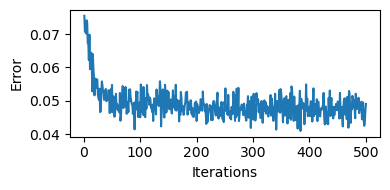

In [14]:
# Plot error
figure(figsize=(4, 2))
ylabel("Error")
xlabel("Iterations")
plot(1:num_iter, errorarr)
tight_layout()

### 重み行列 (受容野)の描画
学習後の重み行列 `Phi` ($\mathbf{\Phi}$)を可視化してみよう．

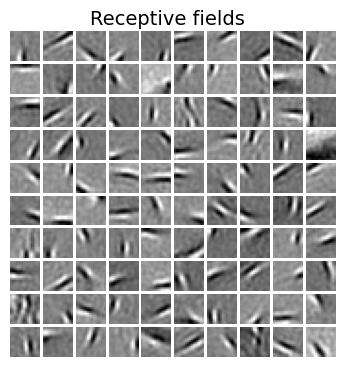

In [15]:
# Plot Receptive fields
figure(figsize=(4.2, 4))
subplots_adjust(hspace=0.1, wspace=0.1)
for i in 1:num_units
    subplot(10, 10, i)
    imshow(reshape(model.Phi[:, i], (sz, sz)), cmap="gray")
    axis("off")
end
suptitle("Receptive fields", fontsize=14)
subplots_adjust(top=0.925)

白色が**ON領域**(興奮)，黒色が**OFF領域**(抑制)を表す．Gaborフィルタ様の局所受容野が得られており，これは一次視覚野(V1)における単純型細胞(simple cells)の受容野に類似している．

### 画像の再構成
学習したモデルを用いて入力画像が再構成されるか確認しよう．

In [16]:
H, W, num_images = size(imgs)
num_inputs = sz^2

# Get the coordinates of the upper left corner of clopping image randomly.
beginx = rand(1:W-sz, batch_size)
beginy = rand(1:H-sz, batch_size)

inputs = zeros(batch_size, num_inputs)  # Input image patches

# Get images randomly
for i in 1:batch_size        
    idx = rand(1:num_images)
    img = imgs[:, :, idx]
    clop = img[beginy[i]:beginy[i]+sz-1, beginx[i]:beginx[i]+sz-1][:]
    inputs[i, :] = clop .- mean(clop)
end

model.r = zeros(batch_size, num_units) # Reset r states

# Input image patches until latent variables are converged 
r_tm1 = zeros(batch_size, num_units)  # set previous r (t minus 1)

for t in 1:nt_max
    # Update r without update weights 
    error = updateOF!(model, model.param, inputs, false)

    dr = model.r - r_tm1 

    # Compute norm of r
    dr_norm = sqrt(sum(dr.^2)) / sqrt(sum(r_tm1.^2) + 1e-8)
    r_tm1 .= model.r # update r_tm1

    # Check convergence of r, then update weights
    if dr_norm < eps
        break
    end
end

神経活動 $\mathbf{r}$がスパースになっているか確認しよう．

In [17]:
println(model.r[1, :])

Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.019152798, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


要素がほとんど0のスパースなベクトルになっていることがわかる．次に画像を再構成する．

In [18]:
reconst = model.r * model.Phi'
println(size(reconst))

(250, 256)


再構成した結果を描画する．

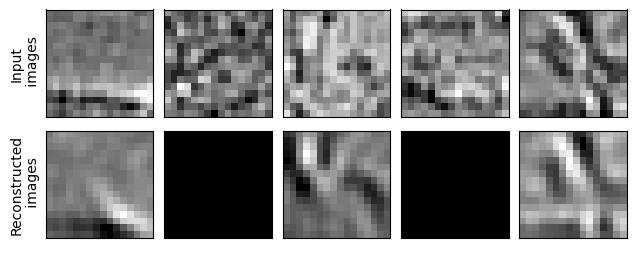

In [19]:
figure(figsize=(7.5, 3))
subplots_adjust(hspace=0.1, wspace=0.1)
num_show = 5
for i in 1:num_show
    subplot(2, num_show, i)
    imshow(reshape(inputs[i, :], (sz, sz)), cmap="gray")
    xticks([]); yticks([]); 
    if i == 1
        ylabel("Input\n images")
    end

    subplot(2, num_show, num_show+i)
    imshow(reshape(reconst[i, :], (sz, sz)), cmap="gray")
    xticks([]); yticks([]); 
    if i == 1
        ylabel("Reconstructed\n images")
    end
end

上段が入力画像，下段が再構成された画像である．差異はあるものの，概ね再構成されていることがわかる．

```{admonition} 論文以外の参考資料
- <http://www.scholarpedia.org/article/Sparse_coding>
- Bruno Olshausen: “Sparse coding in brains and machines”([Stanford talks](https://talks.stanford.edu/bruno-olshausen-sparse-coding-in-brains-and-machines/)), [Slide](http://www.rctn.org/bruno/public/Simons-sparse-coding.pdf)
- <https://redwood.berkeley.edu/wp-content/uploads/2018/08/sparse-coding-ICA.pdf>
- <https://redwood.berkeley.edu/wp-content/uploads/2018/08/sparse-coding-LCA.pdf>
- <https://redwood.berkeley.edu/wp-content/uploads/2018/08/Dylan-lca_overcompleteness_09-27-2018.pdf>
```